In [1]:
%pylab inline
import galsim
import tensorflow_probability as tfp
import tensorflow as tf
import galflow as gf

import jax.numpy as jnp
from functools import partial

Populating the interactive namespace from numpy and matplotlib


## Generate a Galsim example

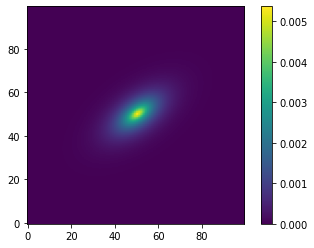

In [2]:
gal_flux = 1.    # counts
gal_r0 = 1.      # arcsec
pixel_scale = 0.2  # arcsec / pixel
N = 100            # image width/height

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=N,ny=N, scale=pixel_scale),
                               x_interpolant='linear')

imgal = gal.drawImage(nx=N, ny=N, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)

imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

g1 = 0.1
g2 = 0.3
g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])

imgal = gf.shear(imgal, g1, g2)

target = imgal.numpy()[0,...,0]
jnp.save("target.npy", target)
imshow(target, origin='lower')
colorbar()

## Fit a Gaussian to the galsim image

In [3]:
import jax
import jax.numpy as jnp
from jax import lax
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
coords = np.stack(meshgrid(arange(-N/2,N/2), arange(-N/2,N/2)), axis=-1)

In [5]:
@jax.jit
def model(tril_params):
  b = tfb.FillScaleTriL(
     diag_bijector=tfb.Softplus(),
     diag_shift=None)
  dist = tfd.MultivariateNormalTriL(loc=[0.,0.], 
                                    scale_tril=b.forward(x=tril_params))
  return dist.prob(coords)

In [6]:
# Let's test it out
params = jnp.ones(3)*5
x = model(params)

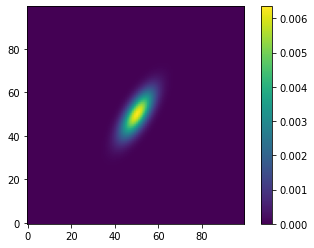

In [7]:
imshow(x, origin='lower')
colorbar()

### Write a first fitting method

In [8]:
from jax.scipy.optimize import minimize

loss = lambda p: jnp.sum((target - model(p))**2)

In [9]:
results = minimize(loss, params, method='BFGS')

In [10]:
# here are our best fit params, and how long it took to get them
results.x, results.nit

(DeviceArray([5.5324473, 3.7328157, 8.21118  ], dtype=float32),
 DeviceArray(19, dtype=int32))

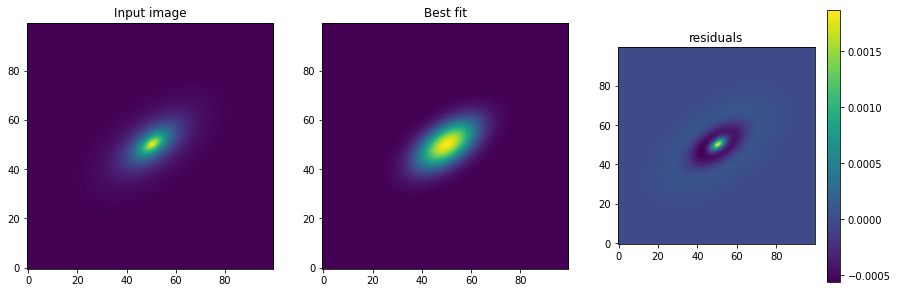

In [11]:
figure(figsize=[15,5])
subplot(131)
imshow(target, origin='lower')
title('Input image')
subplot(132)
imshow(model(results.x), origin='lower')
title('Best fit')
subplot(133)
imshow(target - model(results.x), origin='lower')
title('residuals');
colorbar()

### With iterative method (gradient descent)

In [12]:
# Our fixed point function is just a step of gradient descent trying to minimize
# an l2 loss
f = lambda x, z: z - 2.*jax.grad(lambda t: jnp.sum((x - model(t))**2) )(z)

In [13]:
from jax import lax

@partial(jax.jit, static_argnums=(0,))
def fwd_solver(f, z_init):
  def cond_fun(carry):
    z_prev, z = carry
    return jnp.linalg.norm(z_prev - z) > 1e-6

  def body_fun(carry):
    _, z = carry
    return z, f(z)

  init_carry = (z_init, f(z_init))
  _, z_star = lax.while_loop(cond_fun, body_fun, init_carry)
  return z_star

In [14]:
%%time

# Let's test it out
p = fwd_solver(lambda z: f(target, z), params)

CPU times: user 921 ms, sys: 12 ms, total: 933 ms
Wall time: 938 ms


CPU times: user 11.1 s, sys: 67.2 ms, total: 11.2 s
Wall time: 11.3 s


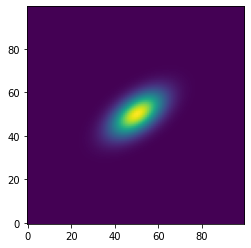

In [15]:
%%time
imshow(model(p), origin='lower')

In [16]:
p

DeviceArray([5.589473, 3.722885, 8.065416], dtype=float32)

## Evaluate ellipticity from covariance matrix

In [17]:
def get_ellipticity(scale_tril):
    b = tfb.FillScaleTriL(
     diag_bijector=tfb.Softplus(),
     diag_shift=None)
    dist = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=b.forward(scale_tril))

    cov = dist.covariance()
    w, v = jnp.linalg.eigh(cov)
    w = jnp.real(w)
    v = jnp.real(v)
    assert (v*cov == cov*v).any()
    
    # ellipse rotation
    x_vec = jnp.array([1, 0])
    cosrotation = (x_vec.T @ v[:,1])/jnp.linalg.norm(x_vec)/jnp.linalg.norm(v[:,1])
    rotation = jnp.arccos(cosrotation)
    R = jnp.array([[jnp.sin(rotation), jnp.cos(rotation)], 
                   [-jnp.cos(rotation), jnp.sin(rotation)]])
    
    r = 10
    x = jnp.sqrt(r * w[0]) # x-radius
    y = jnp.sqrt(r * w[1]) # y-radius
    
    if x <= y:
        b = x
        a = y
    else:
        b = y
        a = x
    
    e_mod = (1-b/a)/(1+b/a)
    e1 = e_mod*jnp.cos(2*rotation)
    e2 = e_mod*jnp.sin(2*rotation)
    
    return jnp.array([e1, -e2])

In [18]:
get_ellipticity(p)

DeviceArray([0.0993493 , 0.29963908], dtype=float32)

### Measure ellipticity with implicit layers

In [19]:
# Now we adapt the fixed_point_layer from the tutorial, merging x and params 
# together

@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def fixed_point_layer(solver, f, x):
  z_star = solver(lambda z: f(x, z), z_init=jnp.ones(3))
  return z_star

def fixed_point_layer_fwd(solver, f, x):
  z_star = fixed_point_layer(solver, f, x)
  return z_star, (x, z_star)

def fixed_point_layer_bwd(solver, f, res, z_star_bar):
  x, z_star = res
  _, vjp_a = jax.vjp(lambda x: f(x, z_star), x)
  _, vjp_z = jax.vjp(lambda z: f(x, z), z_star)
  return vjp_a(solver(lambda u: vjp_z(u)[0] + z_star_bar,
                      z_init=jnp.ones_like(z_star)))
  
fixed_point_layer.defvjp(fixed_point_layer_fwd, fixed_point_layer_bwd)

In [20]:
def get_ellipticity_implicit(img):
    z_star = fixed_point_layer(fwd_solver, f, img)
    return get_ellipticity(z_star)

In [21]:
get_ellipticity_implicit(target)

DeviceArray([0.09986334, 0.29800844], dtype=float32)

In [22]:
jax.jacrev(get_ellipticity_implicit)(target)

CPU times: user 25 s, sys: 192 ms, total: 25.2 s
Wall time: 25 s


DeviceArray([[[-1.4912849e-12, -2.3783551e-12, -3.6670489e-12, ...,
               -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
              [-2.9602341e-12, -4.8743132e-12, -7.7315255e-12, ...,
               -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
              [-5.5390176e-12, -9.4758628e-12, -1.5529496e-11, ...,
               -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
              ...,
              [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
               -4.8225923e-11, -2.9561954e-11, -1.7341639e-11],
              [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
               -2.4500816e-11, -1.5529496e-11, -9.4758628e-12],
              [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
               -1.1851001e-11, -7.7315255e-12, -4.8743132e-12]],

             [[ 5.1454613e-12,  7.2198905e-12,  9.8989749e-12, ...,
               -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
              [ 1.1805394e-11,  1.6818236e-11,  2.34120

### How to draw an ellipse from a gaussian covariance matrix

In [23]:
b = tfb.FillScaleTriL(
     diag_bijector=tfb.Softplus(),
     diag_shift=None)
dist = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=b.forward(results.x))

In [24]:
cov = dist.covariance()
cov

DeviceArray([[67.42793 , 30.651836],
             [30.651836, 44.585594]], dtype=float32)

In [25]:
w, v = jnp.linalg.eig(cov)
w = jnp.real(w)
v = jnp.real(v)
assert (v*cov == cov*v).any()

In [26]:
# ellipsie rotation
x_vec = jnp.array([1, 0])
cosrotation = (x_vec.T @ v[:,1])/jnp.linalg.norm(x_vec)/jnp.linalg.norm(v[:,1])
rotation = jnp.arccos(cosrotation)
R = jnp.array([[jnp.sin(rotation), jnp.cos(rotation)], 
               [-jnp.cos(rotation), jnp.sin(rotation)]])

In [27]:
r = 10
x = jnp.sqrt(r * w[0]) # x-radius
y = jnp.sqrt(r * w[1]) # y-radius

In [28]:
# plot ellipse
theta = np.arange(0, 2*jnp.pi, 0.01)

In [29]:
x_ = x*jnp.cos(theta)
y_ = y*jnp.sin(theta)
coords = R @ jnp.stack([x_, y_], axis=0)

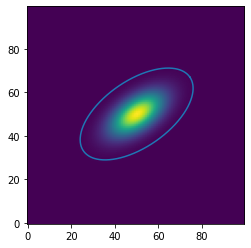

In [30]:
imshow(model(results.x), origin='lower')
plot(coords[0,:]+N/2, coords[1,:]+N/2)